In [612]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Embedding, concatenate, Dense, Flatten, Reshape

In [613]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [614]:
df = pd.read_csv("../../data/processed/lstm.csv")

In [615]:
# only select rows whose id appear in all years where all years are 11
df = df[df['Id'].map(df['Id'].value_counts()) == 11]

In [616]:
df.sample(5)

,Id,Industry,Continent,Country,Year,Employees,Market Cap,Revenue,Employees 1Y Gr,Assets 1Y Gr,...,Cdp Targetscope Percent Mean,Cdp Targetamount Mean,Cdp Targettype Absolute,Cdp Targettype Intensity,Cdp Risk Physical,Cdp Risk Transition,Cdp Aggregated Opp,Investment Counter,Ghg Change Real,Ghg Change Real Next
9071,17673,Capital Goods,North America,USA,4.0,10.827766,23.437736,23.151479,0.690184,0.672185,...,79.0,3.594569,0.0,1.0,1.0,1.0,1.0,1.0,-4.40,-5.10
1833,2880,"Consumer Staples Distribution, Retail",Europe,France,8.0,12.804533,23.313541,25.215877,0.673074,0.687599,...,97.5,3.828641,2.0,2.0,1.0,1.0,1.0,2.0,-6.40,-2.78
1781,2697,"Software, Services",Europe,France,8.0,12.261100,23.532822,23.440222,0.721814,0.717039,...,92.0,3.536117,2.0,1.0,1.0,1.0,1.0,2.0,-7.50,-9.07
427,582,Insurance,North America,USA,4.0,10.601647,24.103052,24.292263,0.703248,0.630563,...,40.0,3.044522,1.0,0.0,1.0,1.0,0.0,1.0,-0.20,-0.26
296,391,"Pharmaceuticals, Biotechnology, Life Sciences",North America,USA,10.0,9.705098,24.313924,22.398304,0.696210,0.702362,...,95.0,2.397895,0.0,2.0,0.0,0.0,1.0,2.0,-4.61,-8.70


In [617]:
df.groupby('Year')['Ghg Change Real Next'].mean()

Year
0.0    -3.281135
1.0    -3.631216
2.0    -3.650946
3.0    -3.927270
4.0    -3.640459
5.0    -4.085919
6.0    -4.620297
7.0    -4.922486
8.0    -4.594297
9.0    -6.535987
10.0   -6.619432
Name: Ghg Change Real Next, dtype: float64

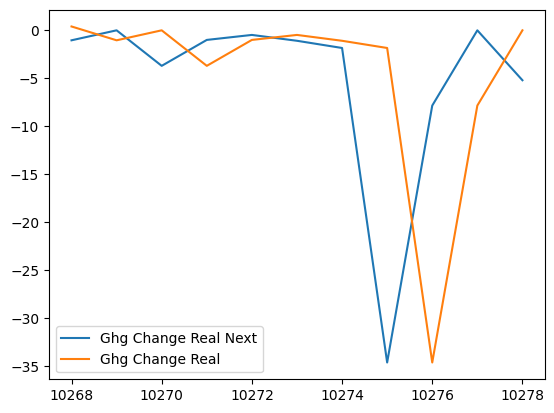

In [618]:
# plot Ghg Change Real Next for firm with id 64
import matplotlib.pyplot as plt
plt.plot(df[df['Id'] == 19856]['Ghg Change Real Next'], label = 'Ghg Change Real Next')
plt.plot(df[df['Id'] == 19856]['Ghg Change Real'], label = 'Ghg Change Real')
plt.legend()
plt.show()

In [619]:
# Identify continuous and binary features
continuous_features = [col for col in df.columns if col not in ['Id', 'Year', 'Ghg Change Real Next', 'Industry', 'Country', 'Continent'] and df[col].nunique() > 2]
binary_features = [col for col in df.columns if df[col].nunique() == 2]

# Calculate mean and standard deviation for continuous features from the first 10 years (assuming these are the training years)
training_data = df[df['Year'] < 10]  # Assuming 'Year' ranges from 0 to 10
train_stats = training_data[continuous_features].agg(['mean', 'std'])


In [620]:
train_stats

,Employees,Market Cap,Revenue,Employees 1Y Gr,Assets 1Y Gr,Tot Assets,Net Income Over Assets,Roe,Ghg1,Ghg2Location,Ghg2Market,Methane Emissions,Cdp Targetscope Percent Mean,Cdp Targetamount Mean,Cdp Targettype Absolute,Cdp Targettype Intensity,Investment Counter,Ghg Change Real
mean,10.209040,23.347818,23.234711,0.701818,0.720368,23.794397,0.717581,0.761443,11.873186,11.514806,3.787879,2.629614,70.108391,2.492226,0.999189,0.956216,1.442162,-3.885535
std,1.438536,1.308612,1.252781,0.054575,0.060587,1.581809,0.025087,0.076937,3.532166,3.633319,5.734378,4.169040,38.345048,1.329364,1.251222,1.086787,1.230923,6.140234


In [621]:

# Function to standardize data (excluding binary features)
def standardize_data(df, stats, continuous_features, binary_features):
    standardized_df = df.copy()
    for feature in continuous_features:
        if feature not in binary_features:  # Only standardize continuous features
            mean = stats.loc['mean', feature]
            std = stats.loc['std', feature]
            standardized_df[feature] = (df[feature] - mean) / std
    # Replace NaN values resulted from standardization with 0 (especially for features with no variance)
    standardized_df = standardized_df.fillna(0)
    return standardized_df


# Standardize the entire dataset based on statistics from the first 10 years
df_standardized = standardize_data(df, train_stats, continuous_features, binary_features)

  # Last year for testing

# Now, you can proceed to create sequences from train_data_standardized and test_data_standardized
# Remember, for LSTM, sequences should be shaped properly according to your model's requirements.


In [622]:
df_standardized

,Id,Industry,Continent,Country,Year,Employees,Market Cap,Revenue,Employees 1Y Gr,Assets 1Y Gr,...,Cdp Targetscope Percent Mean,Cdp Targetamount Mean,Cdp Targettype Absolute,Cdp Targettype Intensity,Cdp Risk Physical,Cdp Risk Transition,Cdp Aggregated Opp,Investment Counter,Ghg Change Real,Ghg Change Real Next
18,64,"Health Care Equipment, Services",North America,USA,0.0,0.833164,1.284628,0.837068,1.859319,0.658832,...,0.779543,0.210900,0.000648,0.040287,1.0,1.0,1.0,-1.171610,0.144218,-3.9
19,64,"Health Care Equipment, Services",North America,USA,1.0,0.840845,1.418461,0.916592,-0.057366,-0.519082,...,0.779543,0.210900,0.000648,0.040287,1.0,1.0,1.0,-1.171610,-0.002356,-3.3
20,64,"Health Care Equipment, Services",North America,USA,2.0,0.840845,1.538127,0.937336,-0.158881,0.364256,...,0.779543,0.210900,0.000648,-0.879857,1.0,1.0,1.0,1.265585,0.095360,-2.4
21,64,"Health Care Equipment, Services",North America,USA,3.0,0.648462,1.114698,0.457114,-2.519531,-2.420317,...,-0.198419,0.508030,0.799866,0.960431,1.0,1.0,1.0,1.265585,0.241935,-2.3
22,64,"Health Care Equipment, Services",North America,USA,4.0,0.724719,1.217597,0.396367,0.873694,-0.694261,...,-0.028906,0.313304,0.799866,0.040287,1.0,1.0,1.0,1.265585,0.258221,-3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12692,32481,Materials,Europe,Finland,6.0,-0.236775,-0.037652,-0.139243,-0.284724,-0.607565,...,0.779543,0.708430,-0.798570,0.040287,1.0,1.0,1.0,-0.359212,0.307079,-6.1
12693,32481,Materials,Europe,Finland,7.0,-0.243976,0.139821,-0.021025,-0.253541,-0.960311,...,0.779543,0.708430,-0.798570,0.040287,1.0,1.0,1.0,-0.359212,-0.360648,-4.0
12694,32481,Materials,Europe,Finland,8.0,-0.248831,-0.014041,-0.019735,-0.222751,0.162544,...,0.388358,0.708430,-0.798570,0.960431,1.0,1.0,1.0,-0.359212,-0.018642,-5.5
12695,32481,Materials,Europe,Finland,9.0,-0.257529,0.223285,-0.056711,-0.273167,-0.013313,...,0.779543,1.276873,0.000648,-0.879857,0.0,0.0,1.0,-0.359212,-0.262932,-0.2


In [623]:
df_standardized.to_csv("../../data/processed/lstm_standardized.csv", index = False)

In [567]:
# one hot encode Industry, Country, Continent type int
industry = pd.get_dummies(df_standardized['Industry'], drop_first=True).astype('int')
country = pd.get_dummies(df_standardized['Country'], drop_first=True).astype('int')
continent = pd.get_dummies(df_standardized['Continent'], drop_first=True).astype('int')


df_standardized = pd.concat([df_standardized, industry, country, continent], axis=1)
df_standardized = df_standardized.drop(columns=['Industry', 'Country', 'Continent'])

In [568]:
# Split the standardized dataset into training and testing
train_data_standardized = df_standardized[df_standardized['Year'] < 10]  # First 10 years for training

# test data is year between 1 and 10
test_data_standardized = df_standardized[df_standardized['Year'] > 6]  # Last year for testing

In [569]:
train_data_standardized

,Id,Year,Employees,Market Cap,Revenue,Employees 1Y Gr,Assets 1Y Gr,Tot Assets,Net Income Over Assets,Roe,...,Switzerland,Thailand,Turkey,USA,United Kingdom,Asia,Europe,North America,Oceania,South America
18,64,0.0,0.833164,1.284628,0.837068,1.859319,0.658832,0.634201,0.563748,0.377679,...,0,0,0,1,0,0,0,1,0,0
19,64,1.0,0.840845,1.418461,0.916592,-0.057366,-0.519082,0.628843,0.610249,0.355329,...,0,0,0,1,0,0,0,1,0,0
20,64,2.0,0.840845,1.538127,0.937336,-0.158881,0.364256,0.689701,0.835341,0.545250,...,0,0,0,1,0,0,0,1,0,0
21,64,3.0,0.648462,1.114698,0.457114,-2.519531,-2.420317,0.405078,0.261056,-0.257972,...,0,0,0,1,0,0,0,1,0,0
22,64,4.0,0.724719,1.217597,0.396367,0.873694,-0.694261,0.386171,0.155803,-0.267021,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12691,32481,5.0,-0.227194,-0.247505,-0.090085,-0.537967,-0.410683,-0.233573,0.334312,-0.137650,...,0,0,0,0,0,0,1,0,0,0
12692,32481,6.0,-0.236775,-0.037652,-0.139243,-0.284724,-0.607565,-0.264026,0.306346,-0.199924,...,0,0,0,0,0,0,1,0,0,0
12693,32481,7.0,-0.243976,0.139821,-0.021025,-0.253541,-0.960311,-0.222800,0.531014,-0.159821,...,0,0,0,0,0,0,1,0,0,0
12694,32481,8.0,-0.248831,-0.014041,-0.019735,-0.222751,0.162544,-0.204935,1.159029,0.124958,...,0,0,0,0,0,0,1,0,0,0


In [570]:
# Assume sequence_length is defined (e.g., 10 years)
sequence_length = 3

# Function to create sequences from the dataset
def create_sequences(data, sequence_length):
    X = []
    y = []
    firm_ids = []
    for firm_id, group in data.groupby('Id'):
        # Ensure the data is sorted by year and drop non-feature columns
        sorted_group = group.sort_values(by='Year').drop(columns=['Id', 'Year', 'Ghg Change Real Next'])
        # Create sequences
        for i in range(len(group) - sequence_length):
            X.append(sorted_group.iloc[i:i+sequence_length].values)  # Features from 'i' to 'i+sequence_length'
            y.append(group.iloc[i+sequence_length]['Ghg Change Real Next'])  # Target value at 'i+sequence_length'
            firm_ids.append(firm_id)
    return np.array(X), np.array(y), np.array(firm_ids)

# Create sequences for training and test sets
X_train, y_train, firm_ids_train = create_sequences(train_data_standardized, sequence_length)
X_test, y_test, firm_ids_test = create_sequences(test_data_standardized, sequence_length)

# Now X_train, y_train, X_test, y_test are ready for LSTM model


In [571]:
X_train.shape

(2590, 3, 95)

In [586]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, RepeatVector, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Set parameters
num_firms = 370  # Number of unique firms
max_time_steps = 3  # Maximum number of time steps in your time series data
num_features = X_train.shape[2]  # Assuming X_train is your training dataset
embedding_dim = 32  # Dimensionality of firm ID embedding

# Define model inputs
firm_ids_input = Input(shape=(1,), dtype='int32', name='firm_ids')
timeseries_input = Input(shape=(max_time_steps, num_features), name='timeseries')

# Embedding layer for firm IDs
firm_embedding = Embedding(output_dim=embedding_dim, input_dim=num_firms, input_length=1)(firm_ids_input)
firm_embedding = tf.squeeze(firm_embedding, axis=1)  # Remove the sequence length dimension
firm_embedding_expanded = RepeatVector(max_time_steps)(firm_embedding)  # Repeat the firm embedding for each time step
firm_embedding_expanded = BatchNormalization()(firm_embedding_expanded)  # Normalize embedding

# Merge firm embedding with time series data
merged_input = Concatenate(axis=-1)([timeseries_input, firm_embedding_expanded])

# LSTM layers for processing the combined input
lstm_out = LSTM(128, return_sequences=True, dropout=0.25, recurrent_dropout=0.25, kernel_regularizer=l2(0.01))(merged_input)
lstm_out = LSTM(64, dropout=0.25, recurrent_dropout=0.25, kernel_regularizer=l2(0.01))(lstm_out)

# Dense layers for prediction
dense_out = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(lstm_out)
dense_out = Dropout(0.5)(dense_out)  # Add dropout
dense_out = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dense_out)

# Final output layer
final_output = Dense(1, activation='linear', name='decarbonization_rate')(dense_out)  # Predicting decarbonization rate

# Create the model
model = Model(inputs=[firm_ids_input, timeseries_input], outputs=[final_output])

# Compile the model with an adaptive learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')  # Use Mean Squared Error as loss function

# Print model summary
model.summary()


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 firm_ids (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_31 (Embedding)    (None, 1, 32)                11840     ['firm_ids[0][0]']            
                                                                                                  
 tf.compat.v1.squeeze_12 (T  (None, 32)                   0         ['embedding_31[0][0]']        
 FOpLambda)                                                                                       
                                                                                                  
 repeat_vector_1 (RepeatVec  (None, 3, 32)                0         ['tf.compat.v1.squeeze_

In [587]:
# Fit the model
model.fit([firm_ids_train, X_train], y_train, epochs=20, batch_size=16)

Epoch 1/20


2024-03-03 02:59:32.426401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


162/162 [==============================] - 27s 139ms/step - loss: 54.0771
Epoch 2/20
162/162 [==============================] - 22s 134ms/step - loss: 48.3187
Epoch 3/20
162/162 [==============================] - 20s 125ms/step - loss: 47.3194
Epoch 4/20
162/162 [==============================] - 20s 124ms/step - loss: 46.0530
Epoch 5/20
162/162 [==============================] - 20s 125ms/step - loss: 45.0825
Epoch 6/20
162/162 [==============================] - 20s 123ms/step - loss: 45.0372
Epoch 7/20
162/162 [==============================] - 20s 121ms/step - loss: 44.2795
Epoch 8/20
162/162 [==============================] - 20s 122ms/step - loss: 43.4903
Epoch 9/20
162/162 [==============================] - 20s 122ms/step - loss: 42.4547
Epoch 10/20
162/162 [==============================] - 20s 122ms/step - loss: 43.7107
Epoch 11/20
162/162 [==============================] - 20s 121ms/step - loss: 40.4591
Epoch 12/20
162/162 [==============================] - 21s 131ms/step - lo

In [588]:
# Evaluate the model with test data
model.evaluate([firm_ids_test, X_test], y_test)

2024-03-03 03:06:40.425222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 66ms/step - loss: 92.3311


92.33113098144531

In [589]:
# calculate the root mean squared error
y_pred = model.predict([firm_ids_test, X_test])
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print(f'Root Mean Squared Error: {rmse:.2f}')

2024-03-03 03:06:44.425524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 36ms/step
Root Mean Squared Error: 9.95


In [590]:
# calculate MAE
mae = np.mean(np.abs(y_pred - y_test))
print(f'Mean Absolute Error: {mae:.2f}')

Mean Absolute Error: 6.67


In [591]:
# calcualte R2 using sklearn
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

print(f'R2: {r2:.2f}')

R2: -0.02


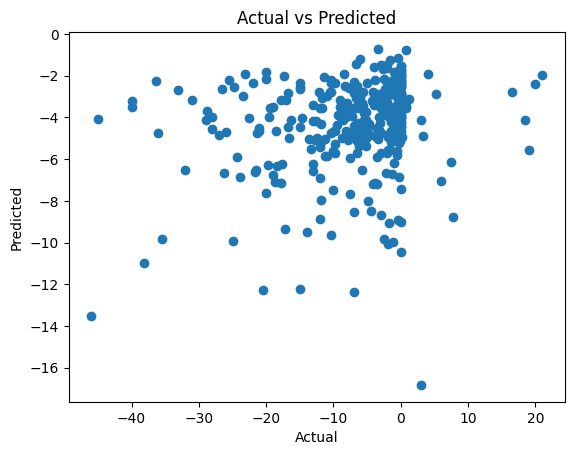

In [592]:
# plot the actual vs predicted
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()